# Swirl correction
The purpose of the project is to identify and correct the portion of the input image affected by a moderate swirl effect.

The center, radius and intensity of the swirl is variable.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import swirl, resize
from skimage.draw import disk
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

In [15]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

The `NEW_TRAINING` variable is used to control whether the models should be trained from scratch or loaded from pre-trained weights. If `NEW_TRAINING` is set to `True`, the notebook will train the segmentation and reconstruction models using the provided datasets. If set to `False`, the notebook will instead load pre-trained weights for both models.

In [ ]:
# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32  # max pixel radius of swirl defect
STRENGTH = 4 #max swirl strength

NEW_TRAINING = False

In [17]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [18]:
def generate_swirl_defect(image_np):
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

In [19]:
# === DATA GENERATOR ===
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True, res=""):
        self.images = images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.res = res

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_clean = self.images[batch_indices]
        batch_defected = []
        batch_masks = []
        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected.append(swirled)
            batch_masks.append(mask)
        if self.res == "all":
            return np.array(batch_defected), np.array(batch_masks), np.array(batch_clean)
        else:
            return np.array(batch_defected), np.array(batch_clean)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [20]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image) #.take(num_train + num_val + num_test)
    all_images = tf.stack(list(ds))
    print(len(all_images))
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

In [21]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = SwirlDefectGenerator(train_imgs, batch_size=32,res="all")
val_gen = SwirlDefectGenerator(val_imgs, batch_size=32, res="all")
test_gen = SwirlDefectGenerator(test_imgs, batch_size=32,res="all")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.N0FHJA_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
3670


In [ ]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
x_batch, y_mask, y_clean = test_gen[idx]
print(y_clean.shape)
y_clean = y_clean[:,:,:,0:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch[0])
plt.title("Swirled Image")

plt.subplot(1, 3, 2)
plt.imshow(y_mask[0].squeeze(), cmap='gray')
plt.title("Defect Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_clean[0])
plt.title("Original Image")
plt.show()


## Pipeline Overview

We tackle the problem in two steps, each handled by its own U-Net model:

1. **Segmentation Model**
   - **Goal**: Generate a precise 128×128 binary mask of the swirl defect.
   - **Architecture**:
     - **Encoder**: Four downsampling stages with filters [16, 32, 64, 128]. Each stage has two 3×3 Conv + ReLU layers followed by 2×2 MaxPool.
     - **Bottleneck**: Two 3×3 Conv layers (256 filters).
     - **Decoder**: Four upsampling stages (Conv2DTranspose) with skip connections, halving filters back to 16.
     - **Output**: 1×1 Conv + Sigmoid activation.
   - **Training**:
     - **Loss**: Binary Cross-Entropy + Dice loss.
     - **Metric**: Intersection over Union (IoU).
     - **Optimizer**: Adam (default settings).
     - **Data**: `SwirlDefectGenerator` wrapper producing (defected_image, true_mask) pairs.
     - **Batch**: 32.
     - **Schedule**: Up to 25 epochs, `EarlyStopping(patience=3)` on validation IoU.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Model for Swirl Mask Estimation 
def build_mask_model(base_filters=16, img_size=128):
    inp = layers.Input(shape=(img_size, img_size, 3))
    # Encoder
    c1 = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(inp)
    c1 = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    c2 = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(p1)
    c2 = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    c3 = layers.Conv2D(base_filters*4, 3, padding='same', activation='relu')(p2)
    c3 = layers.Conv2D(base_filters*4, 3, padding='same', activation='relu')(c3)
    p3 = layers.MaxPooling2D(2)(c3)
    c4 = layers.Conv2D(base_filters*8, 3, padding='same', activation='relu')(p3)
    c4 = layers.Conv2D(base_filters*8, 3, padding='same', activation='relu')(c4)
    # Decoder
    u5 = layers.Conv2DTranspose(base_filters*4, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(base_filters*4, 3, padding='same', activation='relu')(u5)
    c5 = layers.Conv2D(base_filters*4, 3, padding='same', activation='relu')(c5)
    u6 = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(u6)
    c6 = layers.Conv2D(base_filters*2, 3, padding='same', activation='relu')(c6)
    u7 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(u7)
    c7 = layers.Conv2D(base_filters, 3, padding='same', activation='relu')(c7)
    mask_out = layers.Conv2D(1, 1, padding='same', activation='sigmoid', name="mask")(c7)
    return models.Model(inp, mask_out, name="MaskModel")

In [ ]:
mask_model = build_mask_model(base_filters=16, img_size=128)
mask_model.summary()

# Compile the segmentation model with combined loss (BCE + Dice) and IoU metric
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return 1 - (2. * intersection + smooth) / (union + smooth)

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(tf.maximum(y_true, y_pred_bin))
    return intersection / (union + 1e-6)

mask_model.compile(optimizer='adam',
                   loss=lambda yt, yp: tf.keras.losses.binary_crossentropy(yt, yp) + dice_loss(yt, yp),
                   metrics=['accuracy', iou_metric])

Model: "MaskModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_29[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_31[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_33[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_35[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 32, 32,    │     32,832 │ conv2d_36[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │     73,792 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_37[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 64, 64,    │      8,224 │ conv2d_38[0][0] 

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_mask_gen = SwirlDefectGenerator(train_imgs, batch_size=32, res="all")
val_mask_gen   = SwirlDefectGenerator(val_imgs, batch_size=32, res="all")

class MaskGenWrapper(tf.keras.utils.Sequence):
    def __init__(self, swirl_gen):
        self.swirl_gen = swirl_gen
    def __len__(self):
        return len(self.swirl_gen)
    def __getitem__(self, idx):
        x_defected, x_mask, _ = self.swirl_gen[idx]
        return x_defected, x_mask  # output: (defected image, target mask)
    def on_epoch_end(self):
        self.swirl_gen.on_epoch_end()

mask_train_gen = MaskGenWrapper(train_mask_gen)
mask_val_gen   = MaskGenWrapper(val_mask_gen)

# Masked Model Training
if(NEW_TRAINING):
  mask_model.fit(mask_train_gen, validation_data=mask_val_gen, epochs=25,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                ])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.8205 - iou_metric: 0.0131 - loss: 1.3097 - val_accuracy: 0.8887 - val_iou_metric: 0.0000e+00 - val_loss: 1.0887
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 321ms/step - accuracy: 0.8879 - iou_metric: 0.0076 - loss: 1.0850 - val_accuracy: 0.8874 - val_iou_metric: 0.0173 - val_loss: 1.0601
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - accuracy: 0.8453 - iou_metric: 0.1572 - loss: 1.0466 - val_accuracy: 0.8513 - val_iou_metric: 0.2236 - val_loss: 1.0134
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 320ms/step - accuracy: 0.8562 - iou_metric: 0.2134 - loss: 1.0118 - val_accuracy: 0.8580 - val_iou_metric: 0.2510 - val_loss: 0.9688
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 318ms/step - accuracy: 0.8710 - iou_metric: 0.2615 - loss: 0.9397 - val_accuracy: 0.8879 - val_iou_metric: 0.3016 - val_loss: 0.8740
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - accuracy: 0.8807 - iou_metric: 0.2996 - loss: 0.8843 - val_accurac


2. **Reconstruction Model**
   - **Goal**: Inpaint the masked region by predicting an RGB residual.
   - **Input**: Concatenate the 128×128 RGB image with the predicted mask (fourth channel).
   - **Architecture**:
     - **Encoder**: Three downsampling blocks with filters [64, 128, 256].
     - **Bottleneck**: Two 3×3 Conv layers (256 filters).
     - **Decoder**: Three upsampling blocks (Conv2DTranspose) with skip connections, filters [128, 64, 64].
     - **Output**: 1×1 Conv producing a 3-channel residual, applied only within the mask and added back to the input.
   - **Training**:
     - **Loss**: 0.9·MSE + 0.1·(1 – SSIM).
     - **Optimizer**: AdamW (lr=1e-3, weight_decay=1e-4, clipnorm=1.0).
     - **LR Schedule**: Linear warm-up (1e-4→1e-3 over the first 5 epochs), then constant.
     - **Callbacks**: `EarlyStopping(patience=5)`, warm-up scheduler, `ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)`.
     - **Data**: `SwirlDefectGenerator` producing (defected_image, original_image) pairs.
     - **Batch**: 32.
     - **Schedule**: Up to 40 epochs with early stopping on validation loss.


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Concatenate,
    Add,
    Multiply
)
from tensorflow.keras.layers import concatenate

def build_reconstruction_model(seg_model, img_size=128):
    seg_model.trainable = False  # Freeze the segmentation model
    inp = Input(shape=(img_size, img_size, 3))
    # Get predicted mask from the frozen segmentation model
    mask_pred = seg_model(inp)
    x = Concatenate(axis=3)([inp, mask_pred])

    # Encoder: downsampling conv blocks
    c1 = Conv2D(64, 3, activation='relu', padding='same')(x)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(2)(c3)

    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)

    # Decoder: upsampling conv blocks
    u5 = Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)
    u6 = Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)
    u7 = Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    residual = Conv2D(3, 1, activation='linear')(c7)         
    masked_residual = Multiply()([residual, mask_pred])      
    output_img = Add(name="output")([inp, masked_residual])  

    return models.Model(inp, output_img, name="ReconstructionModel")

recon_model = build_reconstruction_model(mask_model)
recon_model.summary()

Model: "ReconstructionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaskModel           │ (None, 128, 128,  │    482,033 │ input_layer_4[0]… │
│ (Functional)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Concatenate)       │ 4)                │            │ MaskModel[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │      2,368 │ concatenate_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_58[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_60[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_62[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │    590,080 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_64[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 32, 32,    │    131,200 │ conv2d_65[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ conv2d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │    442,496 │ concatenate_15[0

 Total params: 3,837,236 (14.64 MB)

 Trainable params: 3,355,203 (12.80 MB)

 Non-trainable params: 482,033 (1.84 MB)

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau


def mixed_loss(y_true, y_pred):
    return 0.9 * tf.keras.losses.MSE(y_true, y_pred) + 0.1 * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)))

recon_model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4, clipnorm=1.0),
    loss=mixed_loss
)

def lr_schedule(epoch):
    # Warmup for first 5 epochs
    if epoch < 5:
        return float(1e-4 + (1e-3 - 1e-4) * (epoch / 5))
    # Cosine decay
    cosine_term = np.cos((epoch - 5) / (40 - 5) * np.pi)
    return float(1e-3 * 0.5 * (1 + cosine_term))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


recon_train_gen = SwirlDefectGenerator(train_imgs, batch_size=32)
recon_val_gen   = SwirlDefectGenerator(val_imgs, batch_size=32)



# Train the reconstruction model
if(NEW_TRAINING):
  recon_model.fit(recon_train_gen, validation_data=recon_val_gen, epochs=40, callbacks=[
      tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
      lr_callback,
      ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
  ])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 53s 411ms/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00028000000000000003.
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 2.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00046.
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - loss: 0.0014 - val_loss: 0.0013 - learning_rate: 4.6000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00064.
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - loss: 0.0014 - val_loss: 0.0013 - learning_rate: 6.4000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0008200000000000001.
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - loss: 0.0014 - val_loss: 0.0013 - learning_rate: 8.2000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epo

# Evaluation metric

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

if(not NEW_TRAINING):

  !gdown --id 1fgBqBUtBZqprNM8LiS0yJW3QYPolbF8e -O mask_model.weights.h5
  !gdown --id 13s0FtsTsUg0Yu8vNqinUXRDzNTvswKgw -O recon_model.weights.h5
  
  # Build the mask model and load weights
  mask_model = build_mask_model(base_filters=16, img_size=128)
  mask_model.load_weights('mask_model.weights.h5')

  # Build the reconstruction model and load weights
  recon_model = build_reconstruction_model(mask_model, img_size=128)
  recon_model.load_weights('recon_model.weights.h5')


In [ ]:
import numpy as np

batch_scores = []

test_gen = SwirlDefectGenerator(test_imgs, batch_size=32, res="all")

# Iterate over all batches in the test set
for i in range(len(test_gen)):
    # Extract the i-th batch: defected images, masks, and ground-truth clean
    x_defected, x_mask, y_clean = test_gen[i]

    # 1) Compute the initial error (MSE) between defected image and original
    #    – for each image: mean over pixels and channels, weighted by the mask
    initial_mse_imgs = np.mean((x_defected - y_clean)**2 * x_mask, axis=(1,2,3))
    #    – for the batch: mean of the MSE for each image
    initial_mse_batch = np.mean(initial_mse_imgs)

    # 2) Apply the model onto the images
    # generated = model.predict([x_defected, x_mask])
    generated = recon_model.predict(x_defected)

    # 3) Compute the post-repair error, still MSE and still masked
    generated_mse_imgs = np.mean((generated - y_clean)**2 * x_mask, axis=(1,2,3))

    # 4) Ratio between reconstructed error and initial error:
    #    for each image, then take the mean over the batch
    mean_ratio = np.mean(generated_mse_imgs / initial_mse_batch)
    print(f"Generated: {np.mean(generated_mse_imgs)}, Initial: {initial_mse_batch:.4f}")
    print(f"Average score (Generated / Initial) for batch {i}: {mean_ratio:.4f}")

    # 5) Save the score for this batch
    batch_scores.append(mean_ratio)

mean_score = np.mean(batch_scores)
std_score  = np.std(batch_scores)

print(f"Test set performance: mean ratio = {mean_score:.4f}, std = {std_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Generated: 0.00016725902969483286, Initial: 0.0008
Average score (Generated / Initial) for batch 0: 0.1988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Generated: 0.00018930938676930964, Initial: 0.0010
Average score (Generated / Initial) for batch 1: 0.1929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Generated: 0.0001220909325638786, Initial: 0.0007
Average score (Generated / Initial) for batch 2: 0.1666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Generated: 0.00014453375479206443, Initial: 0.0008
Average score (Generated / Initial) for batch 3: 0.1755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Generated: 0.00019940905622206628, Initial: 0.0010
Average score (Generated / Initial) for batch 4: 0.1939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Generated: 0.00013190250319894403, Initial: 0.0007
Average score (Generated / Initial) for batch 5: 0.1800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Generated: 0.00015697217895649374, Initial: 0.0008
Average score (Generated / Initial) fo

### Image quality assessment

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


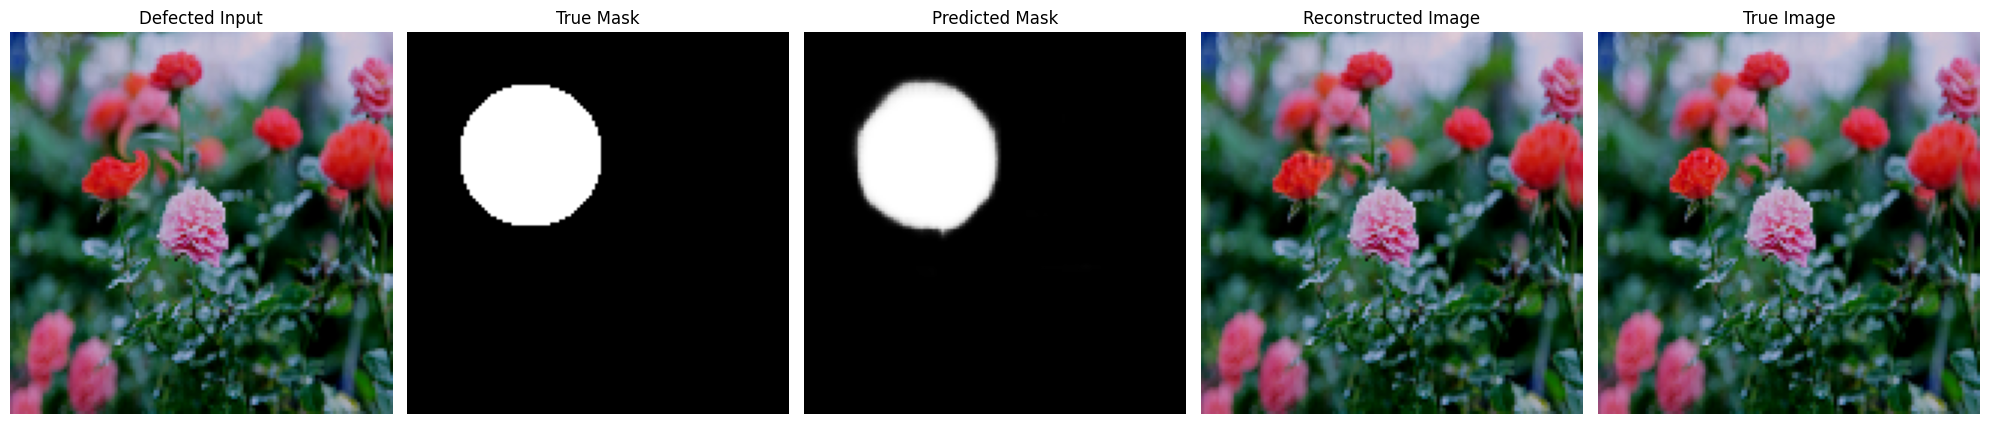

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_defected_batch, y_mask_batch, y_clean_batch = test_gen[0]


x_mask = mask_model.predict(x_defected_batch)
x_predicted = recon_model.predict(x_defected_batch)


input_img   = x_defected_batch[0]
mask_true   = y_mask_batch[0, ..., 0]
mask_img    = x_mask[0]
recon_pred  = x_predicted[0]
clean_img   = y_clean_batch[0]


imgs   = [input_img, mask_true, mask_img, recon_pred, clean_img]
titles = [
    "Defected Input",
    "True Mask",
    "Predicted Mask",
    "Reconstructed Image",
    "True Image"
]


fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img, title in zip(axes, imgs, titles):
    if img.ndim == 2 or img.ndim == 3:
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    else:
        ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()